<!--
 * @file        4_lidar.ipynb
 * @brief       This notebook provides LiDAR data processing and analysis.
 *
 * @authors     Jaehwan Lee (idljh5529@gmail.com)
 *
 * @date        2025-08-12 Released by AI Lab, Hanyang University
 *
-->

# 4. LiDAR (Light Detection And Ranging)

이번 실습에서는 실제 취득한 LiDAR 포인트 클라우드 데이터를 분석해보고, 해당 데이터들을 처리하는 몇 가지 방법에 대해 실습을 진행합니다.

## Table of Contents
1. Open3D 기초
2. 실제 취득한 LiDAR 데이터 시각화 및 분석 (Open3D 활용)
3. ROI Extraction & Downsampling 실습
4. KD Tree 실습
5. Fitting 실습

In [1]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

## 1. Open3D 기초

<img src="../resources/ch4/open3d_logo_horizontal.png" width="50%">

Open3D is an open-source library that supports rapid development of software that deals with 3D data.

The Open3D frontend exposes a set of carefully selected data structures and algorithms in both C++ and Python. 


### Core features
- 3D data structures
- 3D data processing algorithms
- Scene reconstruction
- Surface alignment
- 3D visualization with Physically based rendering (PBR)
- 3D machine learning support with PyTorch and TensorFlow
- GPU acceleration for core 3D operations
- Available in C++ and Python with a 3D viewer app

### 1-1. Basic Setup and Import

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Check Open3D version
print(f"Open3D version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Open3D version: 0.17.0


### 1-2. Point Cloud Creation and Visualization

Random Points Generation

In [17]:
## 2. Point Cloud Creation and Visualization

# Create a simple point cloud from random points
num_points = 1000
points = np.random.rand(num_points, 3) # numpy array of shape (num_points, 3)

# Create Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Add colors (random colors)
colors = np.random.rand(num_points, 3)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Basic information about the point cloud
print(f"Number of points: {len(pcd.points)}")
print(f"Has colors: {pcd.has_colors()}")
print(f"Has normals: {pcd.has_normals()}")
print(f"Point cloud dimensions: {np.asarray(pcd.points).shape}")

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], 
                                 window_name="Random Point Cloud",
                                 width=800, height=600)

Number of points: 1000
Has colors: True
Has normals: False
Point cloud dimensions: (1000, 3)


Sphere Points Generation

In [5]:
# Create a structured point cloud (sphere)
radius = 1.0
num_points = 2000

# Generate random points on a sphere
azimuth = np.random.uniform(0, 2 * np.pi, num_points)   # 0 ~ 360 degrees
elevation = np.random.uniform(-np.pi/2, np.pi/2, num_points)  # -90 ~ 90 degrees

x = radius * np.cos(elevation) * np.cos(azimuth)
y = radius * np.cos(elevation) * np.sin(azimuth)
z = radius * np.sin(elevation)

# Numpy column stack
points = np.column_stack((x, y, z)) # 여러 개의 1차원 배열을 입력으로 받아, 각 배열을 열(column)로 하는 2차원 배열을 생성

# Create point cloud
sphere_pcd = o3d.geometry.PointCloud()
sphere_pcd.points = o3d.utility.Vector3dVector(points)

# Color based on height (z-coordinate)
colors = plt.cm.viridis((z - z.min()) / (z.max() - z.min()))[:, :3]
sphere_pcd.colors = o3d.utility.Vector3dVector(colors)

# 좌표계 추가
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)

# TODO: Visualize with coordinate frame (sphere_pcd, coordinate_frame)
o3d.visualization.draw_geometries([sphere_pcd, coordinate_frame],
                                 window_name="Sphere Point Cloud",
                                 width=800, height=600)

### 1-3. Saving and Loading Point Clouds

Save Sphere Points to each point cloud extentions.

In [6]:
# Save the sphere point cloud to file
output_dir = "output/pcd"
os.makedirs(output_dir, exist_ok=True)

# Save in different formats
pcd_path = os.path.join(output_dir, "sphere.pcd")
ply_path = os.path.join(output_dir, "sphere.ply")
xyz_path = os.path.join(output_dir, "sphere.xyz")

# TODO: Save point cloud
o3d.io.write_point_cloud(pcd_path, sphere_pcd)
o3d.io.write_point_cloud(ply_path, sphere_pcd)
o3d.io.write_point_cloud(xyz_path, sphere_pcd)

print(f"Point cloud saved to:")
print(f"  - {pcd_path}")
print(f"  - {ply_path}")
print(f"  - {xyz_path}")

# Load point cloud from file
loaded_pcd = o3d.io.read_point_cloud(ply_path)
print(f"\nLoaded point cloud:")
print(f"  - Number of points: {len(loaded_pcd.points)}")
print(f"  - Has colors: {loaded_pcd.has_colors()}")
print(f"  - Has normals: {loaded_pcd.has_normals()}")

# Visualize loaded point cloud
o3d.visualization.draw_geometries([loaded_pcd], 
                                 window_name="Loaded Point Cloud",
                                 width=800, height=600)


Point cloud saved to:
  - output/pcd/sphere.pcd
  - output/pcd/sphere.ply
  - output/pcd/sphere.xyz

Loaded point cloud:
  - Number of points: 2000
  - Has colors: True
  - Has normals: False


## 1-4. Load example point cloud

In [7]:
# Load and visualize example point clouds
data_dir = "../data/lidar_pcd"

# Load bunny point cloud
bunny_path = os.path.join(data_dir, "bunny_pc.ply")
if os.path.exists(bunny_path):
    bunny_pcd = o3d.io.read_point_cloud(bunny_path) # TODO: Replace xxxxxx with the correct variable
    print(f"Bunny point cloud:")
    print(f"  - Number of points: {len(bunny_pcd.points)}")
    print(f"  - Has colors: {bunny_pcd.has_colors()}")
    print(f"  - Has normals: {bunny_pcd.has_normals()}")

    # 좌표계 추가
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
    
    # Visualize bunny point cloud
    o3d.visualization.draw_geometries([bunny_pcd, coordinate_frame], 
                                     window_name="Bunny Point Cloud",
                                     width=800, height=600)
else:
    print(f"Bunny point cloud file not found: {bunny_path}")

Bunny point cloud:
  - Number of points: 4093
  - Has colors: True
  - Has normals: True


## 2. LiDAR 데이터 시각화 및 분석

실제 여러 가지 LiDAR를 통해 취득한 포인트 클라우드 데이터를 시각화하고 분석하겠습니다.

### 2-1. VLP-16

In [8]:
# load VLP-16 point cloud data.
vlp16_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/vlp16_1497708191392272.pcd") # AILAB point cloud data
print("Original Point Cloud:", len(vlp16_pcd.points), "points")

# visualize the point cloud
geometries = []
# 포인트 클라우드 추가
geometries.append(vlp16_pcd)
# 좌표계 추가
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
geometries.append(coordinate_frame)
o3d.visualization.draw_geometries(geometries)

Original Point Cloud: 27092 points


### 2-2. VLP-32C

In [9]:
# load VLP-32C point cloud data.
vlp32c_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/vlp32c_1679319638860873.pcd") # AILAB point cloud data
print("Original Point Cloud:", len(vlp32c_pcd.points), "points")

# visualize the point cloud
geometries = []
# 포인트 클라우드 추가
geometries.append(vlp32c_pcd)
# 좌표계 추가
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
geometries.append(coordinate_frame)
o3d.visualization.draw_geometries(geometries)

Original Point Cloud: 50568 points


In [10]:
# VLP 16과 비교
vlp16_pcd_colored = vlp16_pcd.paint_uniform_color([1, 0, 0])
vlp32c_pcd_colored = vlp32c_pcd.paint_uniform_color([0, 1, 0])

# 두 포인트 클라우드를 시각화
o3d.visualization.draw_geometries([vlp16_pcd_colored, vlp32c_pcd_colored])

### 2-3. Ruby Plus

In [41]:
# load Ruby Plus point cloud data.
ruby_plus_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/ruby_1751004403283928.pcd") # AILAB point cloud data
print("Original Point Cloud:", len(ruby_plus_pcd.points), "points")

# visualize the point cloud
geometries = []
# 포인트 클라우드 추가
geometries.append(ruby_plus_pcd)
# 좌표계 추가
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
geometries.append(coordinate_frame)
o3d.visualization.draw_geometries(geometries)

Original Point Cloud: 230400 points


In [12]:
# VLP 32C와 비교
ruby_plus_colored = ruby_plus_pcd.paint_uniform_color([1, 0, 0])
vlp32c_colored = vlp32c_pcd.paint_uniform_color([0, 1, 0])

# 두 포인트 클라우드를 시각화
o3d.visualization.draw_geometries([ruby_plus_colored, vlp32c_colored])

### 2-4. RS-LiDAR-M1

이전 Mechanical (spinning) LiDAR와 다르게, 해당 LiDAR는 MEMS solid-state LiDAR입니다.  

다른 포인트 클라우드 데이터와 비교하여 시각화해보세요.

In [13]:
# load RS-LiDAR-M1 point cloud data.
m1_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/m1_1751004403277387.pcd") # AILAB point cloud data
print("Original Point Cloud:", len(m1_pcd.points), "points")

# 유효하지 않은 점(NaN, Inf) 제거
m1_pcd.remove_non_finite_points()
print("Valid Point Cloud:", len(m1_pcd.points), "points")

# 시각화
if m1_pcd.has_points():
    # 좌표계와 함께 시각화
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
    o3d.visualization.draw_geometries([m1_pcd, coordinate_frame])
else:
    print("No valid points to display.")

Original Point Cloud: 78750 points
Valid Point Cloud: 65976 points


In [14]:
# Ruby Plus와 비교
ruby_plus_colored = ruby_plus_pcd.paint_uniform_color([1, 0, 0])
m1_colored = m1_pcd.paint_uniform_color([0, 1, 0])

# 두 포인트 클라우드를 시각화
o3d.visualization.draw_geometries([ruby_plus_colored, m1_colored])

## 3. ROI Extraction & Downsampling

고속 도로 상황에서의 LiDAR 포인트 클라우드를 ROI Extraction 및 Downsampling을 진행합니다.

In [15]:
# load 고속 도로 상황에서의 point cloud data.
pcd = o3d.io.read_point_cloud("../data/lidar_pcd/ailab_pc_data_240627_18-59-00-363.pcd") # AILAB point cloud data
print("Original Point Cloud:", len(pcd.points), "points")

# visualize the point cloud
geometries = []
# 포인트 클라우드 추가
geometries.append(pcd)
# 좌표계 추가
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
geometries.append(coordinate_frame)
o3d.visualization.draw_geometries(geometries)

Original Point Cloud: 43080 points


### 3-1. ROI(Region of Interest) 추출
주변 객체 탐지에 필요한 영역만을 선별하여 처리 속도를 향상시키고 불필요한 노이즈를 제거합니다.

또한 자차에 맺힌 포인트로 False positive가 생기는 것을 방지하기 위해, 자차 주변 포인트를 제거합니다. 

해당 실습에서는 다음과 같은 관심 영역을 설정합니다:
- **X축 범위**: 전후 60m 정도 (-60m ~ +60m)
- **Y축 범위**: 좌우 40m 정도 (-40m ~ +40m)  
- **Z축 범위**: 지면 아래 10m ~ 지면 위 10m (-10m ~ +10m)

In [16]:
# 커스텀 모듈 임포트
from tutlibs.lidar.custom_lidar import custom_extract_roi

print("=== ROI 추출: 먼 거리의 포인트 제거 ===")
# ROI 파라미터 설정
roi_x_range = (-60, 60)  # X축 범위: 전후 60m
roi_y_range = (-40, 40)  # Y축 범위: 좌우 40m  
roi_z_range = (-10, 10)  # Z축 범위: 위아래 10m

# ROI 영역 추출
roi_pcd, far_pcd = custom_extract_roi(pcd, roi_x_range, roi_y_range, roi_z_range) # TODO: custom_extract_roi 함수 완성

# 먼 거리에 존재하는 포인트들의 색을 다르게 하여 시각화
far_pcd.paint_uniform_color([0.3, 0.3, 0.3])
o3d.visualization.draw_geometries([roi_pcd, far_pcd], 
                                window_name="ROI Result")

=== ROI 추출: 먼 거리의 포인트 제거 ===


### 3-3. Remove Ego Surround Points
자차 주변에 근접한 포인트를 제거합니다.
x: -2.5, 2.0
y: -1.0, 1.0
z: -10.0, 10.0

In [18]:
# 1-3-3. ROI 재추출 - EGO 차량 주변 포인트 제거
ego_roi_x_range = (roi_x_range[0], roi_x_range[1])  # TODO: X축 범위
ego_roi_y_range = (roi_y_range[0], roi_y_range[1])  # TODO: Y축 범위
ego_roi_z_range = (roi_z_range[0], roi_z_range[1])    # TODO: Z축 범위
# ROI 영역 추출 - 차량 주변이 아닌 바깥 쪽의 포인트들만 사용
ego_pcd, surround_pcd = custom_extract_roi(roi_pcd, ego_roi_x_range, ego_roi_y_range, ego_roi_z_range)
print(f"원하는 영역의 포인트 수: {len(surround_pcd.points)}")

# 주변 영역만 시각화
ego_pcd.paint_uniform_color([0.3, 0.3, 0.3])
o3d.visualization.draw_geometries([surround_pcd, ego_pcd], 
                                window_name="ROI Result")

원하는 영역의 포인트 수: 0


### 3-3. Downsampling (다운샘플링)
다운샘플링을 통해 포인트 수를 줄여 처리 속도를 향상시킵니다.  

뿐만 아니라 Voxel grid sampling을 통해 공간 상의 포인트들을 균일하게 분포시켜 거리에 따른 의존성을 줄입니다.

해당 실슴에서는 Open3D에서 제공하는 voxel grid sampling 함수를 사용할 것이며, 해당 함수의 경우 복셀 평균 점을 대표 점으로 사용합니다.

In [19]:
# Open3D 라이브러리에서 제공하는 voxel grid sampling 함수 사용
voxel_size = 0.5
sampled_pcd_open3d = surround_pcd.voxel_down_sample(voxel_size) # TODO: surround_pcd.voxel_down_sample 함수 적용

# 시각화
o3d.visualization.draw_geometries([sampled_pcd_open3d], 
                                window_name="Voxel Grid Sampling Result")

# 다운샘플링 이전 포인트 클라우드와 비교 시각화   
surround_pcd_color = surround_pcd.paint_uniform_color([1.0, 0.0, 0.0])
sampled_pcd_open3d_color = sampled_pcd_open3d.paint_uniform_color([0.0, 1.0, 0.0])
o3d.visualization.draw_geometries([surround_pcd_color, sampled_pcd_open3d_color], 
                                window_name="Before and After Downsampling")


## 4. KD Tree

### KD-Tree란?

**KD-Tree (k-dimensional tree)**는 k차원 공간의 점들을 효율적으로 검색하기 위한 자료구조입니다. 특히 **최근접 이웃 검색(Nearest Neighbor Search)**과 **범위 검색(Range Search)**에 매우 유용합니다.

<img src="../resources/ch4/neighbors.png" width="30%">

### 주요 특징

1. **이진 트리 구조**: 각 노드는 최대 2개의 자식을 가집니다.
2. **차원별 분할**: 각 레벨에서 하나의 차원(축)을 기준으로 공간을 분할합니다.
3. **균형 트리**: 일반적으로 중앙값(median)을 기준으로 분할하여 균형을 맞춥니다.

### 4-1. 2D에서의 KD-Tree 구축 원리

2차원 공간에서 KD-Tree 구축 과정을 단계별로 살펴보겠습니다:

#### Step 1: 루트 노드 생성
- 전체 점들을 X축 좌표로 정렬
- 중앙값(median)을 가진 점을 루트 노드로 선택
- 이 점을 기준으로 공간을 왼쪽과 오른쪽으로 분할

#### Step 2: 재귀적 분할
- **1레벨 (depth=1)**: X축을 기준으로 분할
  - 왼쪽 서브트리: X좌표의 중앙값으로 분할
  - 오른쪽 서브트리: X좌표의 중앙값으로 분할

- **2레벨 (depth=2)**: 다시 Y축을 기준으로 분할
  - 각 서브트리에서 Y좌표의 중앙값으로 분할

- **반복**: `axis = depth % k` (k=2이므로 X→Y→X→Y...)

#### 시각적 이해

```
초기 점들:     분할 과정:           최종 트리:

●   ●  ●      1) X축 분할          Root(X=50)
  ●     ●      |                  /         \
●   ●  ●      |              Left(Y=30)   Right(Y=70)
  ●     ●      2) Y축 분할        /    \       /     \
●   ●  ●         ----         L-L(X)  L-R(X) R-L(X) R-R(X)
```

#### 핵심 알고리즘

```python
def build_kdtree(points, depth=0):
    k = len(points[0])  # 차원 수
    axis = depth % k    # 현재 분할 축
     
    # 현재 축으로 정렬하여 중앙값 찾기
    points.sort(key=lambda x: x[axis])
    median = len(points) // 2
    
    # 노드 생성 및 재귀 호출
    node = KDNode(points[median])
    node.left = build_kdtree(points[:median], depth+1)
    node.right = build_kdtree(points[median+1:], depth+1)
    
    return node
```

#### 공간 분할의 기하학적 의미

- **X축 분할**: 수직선으로 공간을 좌우로 나눔
- **Y축 분할**: 수평선으로 공간을 위아래로 나눔
- **결과**: 각 리프 노드는 직사각형 영역을 담당
#### 시간 복잡도
 **구축**: O(n log n)  
 **검색**: 평균 O(log n), 최악 O(n)  
 **공간**: O(n)  

### 4-2. k-NN 검색 수행 및 결과 확인

생성된 KD-Tree를 사용하는 k-최근접 이웃 검색은 아래의 방법으로 수행됩니다.

#### KD-Tree k-NN 검색 과정 설명:

1. **초기화**: 쿼리 포인트에서 시작하여 루트 노드부터 탐색을 시작합니다.

2. **하향 탐색 (Downward Traversal)**:
   - 현재 노드의 분할 축(X 또는 Y)을 확인합니다.
   - 쿼리 포인트의 해당 축 좌표와 노드의 좌표를 비교합니다.
   - 작으면 왼쪽 자식으로, 크거나 같으면 오른쪽 자식으로 이동합니다.
   - 리프 노드에 도달할 때까지 반복합니다.

3. **후보 수집**: 방문한 노드들을 k-NN 후보로 추가합니다.

4. **백트래킹 (Backtracking)**:
   - 상위 노드로 돌아가면서 다른 쪽 서브트리도 확인해야 하는지 판단합니다.
   - 현재까지 찾은 k번째 최근접 이웃까지의 거리보다 분할 경계까지의 거리가 더 가까우면 반대편 서브트리도 탐색합니다.
   - 이는 더 가까운 이웃이 반대편에 있을 가능성이 있기 때문입니다.

5. **결과 정리**: 최종적으로 k개의 최근접 이웃을 거리 순으로 정렬하여 반환합니다.

**KD-Tree k-NN 검색의 장점:**
- 전체 포인트를 모두 확인하지 않고도 효율적으로 k-NN을 찾을 수 있습니다.
- 평균적으로 O(log n) 시간 복잡도를 가집니다.
- 공간 분할을 통해 불필요한 계산을 줄일 수 있습니다.

이 과정을 통해 대용량 포인트 클라우드에서도 빠른 이웃 검색이 가능합니다.

In [20]:
# 포인트 클라우드 생성 (성능 비교를 위해)
np.random.seed(123)
large_points = np.random.rand(10000, 3) * 100  # 3D 포인트 10000개

print(f"테스트 데이터: {len(large_points)}개의 3D 포인트")

# 쿼리 포인트들 생성
test_queries = np.random.rand(10, 3) * 100

print(f"테스트 쿼리: {len(test_queries)}개")

테스트 데이터: 10000개의 3D 포인트
테스트 쿼리: 10개


In [22]:
print("=== 트리 구축 시간 확인 ===")
# Open3D 구현체
large_pcd = o3d.geometry.PointCloud()
large_pcd.points = o3d.utility.Vector3dVector(large_points)

start_time = time.perf_counter()
# Open3D 트리 구축
o3d_tree = o3d.geometry.KDTreeFlann(large_pcd) # TODO: Open3D 함수를 사용하여 large_pcd에 KD-Tree 구축, o3d.geometry.KDTreeFlann 함수 사용
o3d_build_time = time.perf_counter() - start_time

print(f"Open3D 트리 구축: {o3d_build_time:.4f}초")

=== 트리 구축 시간 확인 ===
Open3D 트리 구축: 0.0068초


In [23]:
# 커스텀 모듈 임포트
from tutlibs.lidar.custom_lidar import custom_brute_force_search

print("\n=== k-NN 검색 시간 비교 ===")
k = 5

# 일반적인 for문을 통한 search 검색 시간 측정
custom_search_times = []
for query in test_queries[:10]:  # 처음 10개만 테스트
    start_time = time.perf_counter()
    indices, distances = custom_brute_force_search(large_pcd, query, k) # TODO: custom_brute_force_search 함수 완성
    custom_search_times.append(time.perf_counter() - start_time)

# Open3D 검색 시간 측정
o3d_search_times = []
for query in test_queries[:10]:  # 처음 10개만 테스트
    start_time = time.perf_counter()
    [num_neighbors, indices, distances] = o3d_tree.search_knn_vector_3d(query, k) # TODO: search_knn_vector_3d 함수를 사용하여 knn 검색
    o3d_search_times.append(time.perf_counter() - start_time)

avg_custom_time = np.mean(custom_search_times)
avg_o3d_time = np.mean(o3d_search_times)

print(f"Brute-force 평균 검색 시간: {avg_custom_time:.6f}초")
print(f"Open3D 평균 검색 시간: {avg_o3d_time:.6f}초")
print(f"Open3D vs Brute-force 검색 속도비: {avg_custom_time/avg_o3d_time:.2f}x")


=== k-NN 검색 시간 비교 ===
Brute-force 평균 검색 시간: 0.002759초
Open3D 평균 검색 시간: 0.000032초
Open3D vs Brute-force 검색 속도비: 85.28x


In [24]:
print("\n=== 정확성 비교 ===")
    
# 동일한 3D 데이터에서 결과 비교
test_query_3d = test_queries[0]

# 커스텀 구현체 결과
custom_indices, custom_distances = custom_brute_force_search(large_pcd, test_query_3d, k) 

# Open3D 결과  
[num_neighbors, o3d_indices, o3d_distances] = o3d_tree.search_knn_vector_3d(test_query_3d, k) # TODO: o3d_tree.search_knn_vector_3d 함수를 사용하여 knn 검색
o3d_distances = np.sqrt(o3d_distances)  # Open3D는 제곱거리를 반환 --> 유클리드 거리로 변환

print(f"테스트 쿼리 (3D): ({test_query_3d[0]:.2f}, {test_query_3d[1]:.2f}, {test_query_3d[2]:.2f})")

print(f"\n커스텀 구현체 결과 (3D):")
for i, (idx, dist) in enumerate(zip(custom_indices, custom_distances)):
    point = large_points[idx]
    print(f"  {i+1}: 인덱스 {idx}, 거리 {dist:.4f}, 좌표 ({point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f})")

print(f"\nOpen3D 결과 (3D):")
for i, (idx, dist) in enumerate(zip(o3d_indices, o3d_distances)):
    point = large_points[idx]
    print(f"  {i+1}: 인덱스 {idx}, 거리 {dist:.4f}, 좌표 ({point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f})")


=== 정확성 비교 ===
테스트 쿼리 (3D): (89.40, 48.79, 45.71)

커스텀 구현체 결과 (3D):
  1: 인덱스 5616, 거리 3.1862, 좌표 (91.77, 47.03, 44.51)
  2: 인덱스 168, 거리 3.2200, 좌표 (89.39, 49.65, 42.61)
  3: 인덱스 3203, 거리 3.3619, 좌표 (89.11, 49.45, 42.43)
  4: 인덱스 7385, 거리 3.4120, 좌표 (86.41, 48.56, 44.08)
  5: 인덱스 4817, 거리 3.9039, 좌표 (88.72, 48.29, 49.52)

Open3D 결과 (3D):
  1: 인덱스 5616, 거리 3.1862, 좌표 (91.77, 47.03, 44.51)
  2: 인덱스 168, 거리 3.2200, 좌표 (89.39, 49.65, 42.61)
  3: 인덱스 3203, 거리 3.3619, 좌표 (89.11, 49.45, 42.43)
  4: 인덱스 7385, 거리 3.4120, 좌표 (86.41, 48.56, 44.08)
  5: 인덱스 4817, 거리 3.9039, 좌표 (88.72, 48.29, 49.52)



=== 성능 비교 시각화 ===


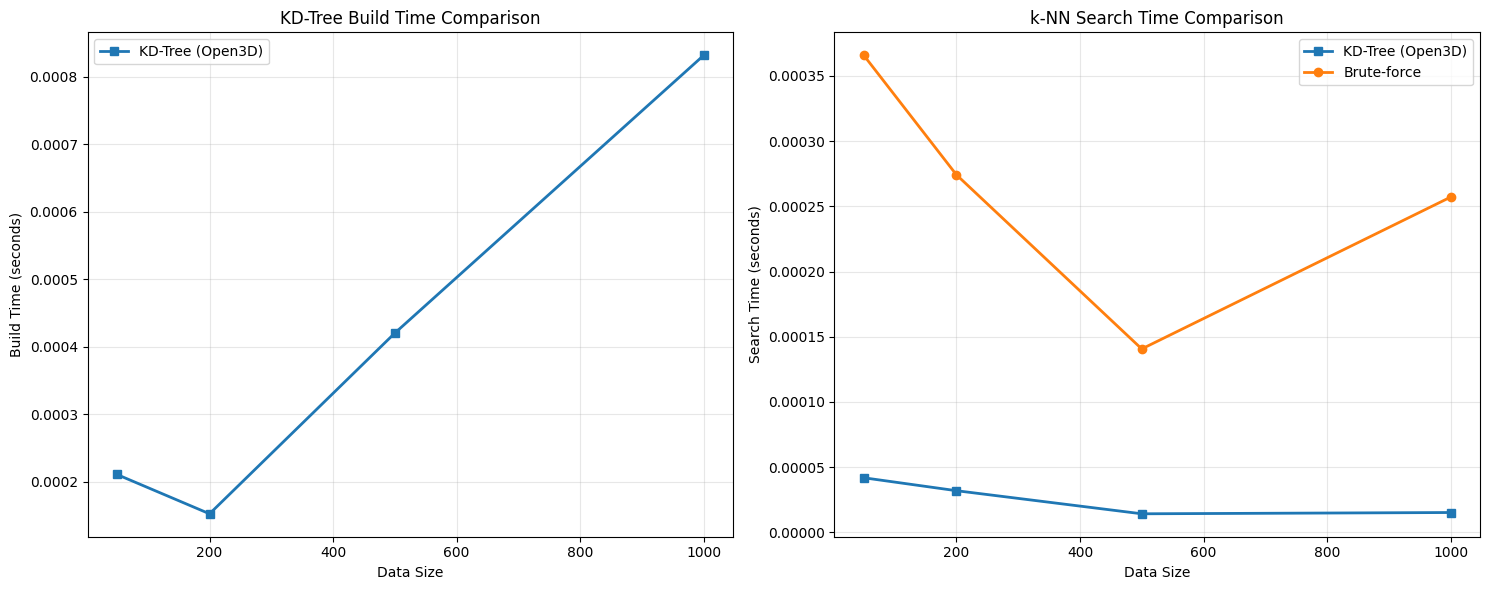

In [25]:
print("\n=== 성능 비교 시각화 ===")
    
# 다양한 데이터 크기에서 성능 비교
sizes = [50, 200, 500, 1000]
o3d_build_times = []
custom_search_times = []
o3d_search_times = []

for size in sizes:
    # 테스트 데이터 생성
    test_data = np.random.rand(size, 3) * 100
    test_query = np.random.rand(3) * 100
    
    # Open3D kd tree 구축 시간
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(test_data)
    start = time.perf_counter()
    o3d_tree = o3d.geometry.KDTreeFlann(pcd)
    o3d_build_times.append(time.perf_counter() - start)
    
    # 검색 시간 (10번 평균)
    custom_times = []
    o3d_times = []
    for _ in range(10):
        start = time.perf_counter()
        custom_indices, custom_distances = custom_brute_force_search(pcd, test_query, 5)
        custom_times.append(time.perf_counter() - start)
        
        start = time.perf_counter()
        o3d_tree.search_knn_vector_3d(test_query, 5)
        o3d_times.append(time.perf_counter() - start)
    
    custom_search_times.append(np.mean(custom_times))
    o3d_search_times.append(np.mean(o3d_times))

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 구축 시간 출력
ax1.plot(sizes, o3d_build_times, 's-', label='KD-Tree (Open3D)', linewidth=2)
ax1.set_xlabel('Data Size')
ax1.set_ylabel('Build Time (seconds)')
ax1.set_title('KD-Tree Build Time Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 검색 시간 비교
ax2.plot(sizes, o3d_search_times, 's-', label='KD-Tree (Open3D)', linewidth=2)
ax2.plot(sizes, custom_search_times, 'o-', label='Brute-force', linewidth=2)
ax2.set_xlabel('Data Size')
ax2.set_ylabel('Search Time (seconds)')
ax2.set_title('k-NN Search Time Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Fitting
<!-- Fitting은 주어진 데이터에 가장 적합한 수학적 모델을 찾는 과정입니다. -->
Fitting은 주어진 포인트 클라우드 데이터에 가장 적합한 수학적 모델(직선, 평면, 구 등)을 찾는 과정입니다.

<!-- 이 절에서는 다음과 같은 피팅 방법들을 소개합니다: -->
이 실습에서는 다음과 같은 피팅 방법들을 학습합니다:
- **Least Squares Fitting (최소 자승법)**: 모든 데이터 포인트를 고려하여 전체 오차를 최소화하는 방법
- **RANSAC (RANdom SAmple Consensus)**: 아웃라이어에 강건한 피팅 방법

다루게 될 기하학적 모델들:
- **직선 피팅**: 2D 공간에서 직선 방정식 y = ax + b 추정
- **구 피팅**: 3D 공간에서 구 방정식 (x-cx)² + (y-cy)² + (z-cz)² = r² 추정


### 5-1. Least Squares Fitting (최소 자승법)
최소 자승법은 모든 데이터 포인트와 모델 사이의 오차 제곱합을 최소화하는 방법입니다.

#### 5-1-1. 포인트 클라우드 생성
노이즈가 포함된 직선과 구 형태의 포인트 클라우드를 생성합니다.

In [30]:
# point cloud 생성 함수들 및 시각화 함수들 불러오기
from tutlibs.lidar.custom_lidar import visualize_line_fitting_result
from tutlibs.pointcloud_io.create_pcd import create_line_pcd

# 직선 파라미터 설정: y = ax + b
true_line_params = np.array([0.5, 1.0])  # a=0.5, b=1.0
print(f"실제 직선 방정식: y = {true_line_params[0]}x + {true_line_params[1]}")

# 직선 포인트 클라우드 생성
line_pcd = create_line_pcd(
    line_params=true_line_params,
    num_points=1000,
    noise_std=0.3      # 가우시안 노이즈 표준편차
)

# 생성된 포인트 클라우드 시각화
print(f"생성된 포인트 개수: {len(line_pcd.points)}")
o3d.visualization.draw_geometries([line_pcd], window_name="Straight point cloud with noise")

실제 직선 방정식: y = 0.5x + 1.0
생성된 포인트 개수: 1000


In [27]:
# point cloud 생성 함수들 및 시각화 함수들 불러오기
from tutlibs.lidar.custom_lidar import visualize_sphere_fitting_result
from tutlibs.pointcloud_io.create_pcd import create_sphere_pcd

# 구 파라미터 설정
true_sphere_center = np.array([2.0, 1.0, 0.5])  # 중심점 (cx, cy, cz)
true_sphere_radius = 3.0                          # 반지름
print(f"실제 구 방정식: (x-{true_sphere_center[0]})² + (y-{true_sphere_center[1]})² + (z-{true_sphere_center[2]})² = {true_sphere_radius}²")

# 구 포인트 클라우드 생성
sphere_pcd = create_sphere_pcd(
    sphere_center=true_sphere_center,
    radius=true_sphere_radius,
    num_points=1500,
    noise_std=0.15      # 가우시안 노이즈 표준편차
)

# 생성된 포인트 클라우드 시각화
print(f"생성된 포인트 개수: {len(sphere_pcd.points)}")
o3d.visualization.draw_geometries([sphere_pcd], window_name="Sphere point cloud with noise")

실제 구 방정식: (x-2.0)² + (y-1.0)² + (z-0.5)² = 3.0²
생성된 포인트 개수: 1500


#### 5-1-2. 직선 피팅 with Least Squares

**직선 피팅:**
- 목적 함수: minimize $Σ(y_i - ax_i - b)²$
- 정규 방정식을 통해 해석적 해 구함

In [28]:
from tutlibs.lidar.custom_lidar import custom_least_squares_line_fitting

# 최소 자승법으로 직선 피팅
estimated_line_params = custom_least_squares_line_fitting(line_pcd) # TODO: custom_least_squares_line_fitting 함수 구현

# 결과 시각화
visualize_line_fitting_result(line_pcd, estimated_line_params, text=f"y={estimated_line_params[0]:.3f}x+{estimated_line_params[1]:.3f}", text_coord=np.array([-10.0, 5.0, 0]))

print("=== 직선 피팅 결과 (Least Squares) ===")
print(f"실제 파라미터:   a={true_line_params[0]:.3f}, b={true_line_params[1]:.3f}")
print(f"추정된 파라미터: a={estimated_line_params[0]:.3f}, b={estimated_line_params[1]:.3f}")
print(f"오차:           a={abs(true_line_params[0]-estimated_line_params[0]):.3f}, b={abs(true_line_params[1]-estimated_line_params[1]):.3f}")


=== 직선 피팅 결과 (Least Squares) ===
실제 파라미터:   a=0.500, b=1.000
추정된 파라미터: a=0.491, b=1.022
오차:           a=0.009, b=0.022


#### 5-1-3. 구 피팅 with Least Squares

**구 피팅:**
- 구 방정식을 선형 형태로 변환하여 해결
- 최소 자승법으로 중심점과 반지름 동시 추정

In [29]:
from tutlibs.lidar.custom_lidar import custom_least_squares_sphere_fitting

# 최소 자승법으로 구 피팅
estimated_center, estimated_radius = custom_least_squares_sphere_fitting(sphere_pcd) # TODO: custom_least_squares_sphere_fitting 함수 구현

# 결과 시각화
visualize_sphere_fitting_result(sphere_pcd, estimated_center, estimated_radius, text=f"(x-{estimated_center[0]:.3f})^2 + (y-{estimated_center[1]:.3f})^2 + (z-{estimated_center[2]:.3f})^2 = {estimated_radius:.3f}^2", text_coord=estimated_center+np.array([-estimated_radius*4, estimated_radius+0.1, 0]))

print("=== 구 피팅 결과 (Least Squares) ===")
print(f"실제 중심점:   ({true_sphere_center[0]:.3f}, {true_sphere_center[1]:.3f}, {true_sphere_center[2]:.3f})")
print(f"추정된 중심점: ({estimated_center[0]:.3f}, {estimated_center[1]:.3f}, {estimated_center[2]:.3f})")
print(f"중심점 오차:   {np.linalg.norm(true_sphere_center - estimated_center):.3f}")
print(f"")
print(f"실제 반지름:   {true_sphere_radius:.3f}")
print(f"추정된 반지름: {estimated_radius:.3f}")
print(f"반지름 오차:   {abs(true_sphere_radius - estimated_radius):.3f}")


=== 구 피팅 결과 (Least Squares) ===
실제 중심점:   (2.000, 1.000, 0.500)
추정된 중심점: (2.014, 1.008, 0.498)
중심점 오차:   0.016

실제 반지름:   3.000
추정된 반지름: 3.010
반지름 오차:   0.010


### 5-2. RANSAC (Random Sample Consensus)
RANSAC은 아웃라이어가 많은 데이터에서 강건한(robust) 피팅을 수행하는 알고리즘입니다.

#### RANSAC 알고리즘 단계:
1. **랜덤 샘플링**: 모델 추정에 필요한 최소 개수의 포인트를 랜덤 선택
2. **모델 피팅**: 선택된 포인트들로 모델 추정
3. **거리 계산**: 모든 포인트와 모델 사이의 거리 계산
4. **Inlier 판정**: 임계값 이하의 거리를 가진 포인트들을 Inlier로 분류
5. **최적 모델 선택**: 가장 많은 Inlier를 가진 모델을 선택
6. **반복**: 위 과정을 지정된 횟수만큼 반복

In [31]:
# RANSAC fitting 함수들 불러오기
from tutlibs.lidar.custom_lidar import (
    custom_ransac_sample_points, custom_fit_line_from_samples, custom_compute_line_distances,
    custom_fit_sphere_from_samples, custom_compute_sphere_distances, custom_find_inliers_outliers
)

#### 5-2-1. 포인트 클라우드 생성
노이즈 뿐만 아니라 Outlier도 포함된 직선과 구 형태의 포인트 클라우드를 생성합니다.

In [32]:
# 직선 파라미터 설정: y = ax + b
true_line_params = np.array([0.5, 1.0])  # a=0.5, b=1.0
print(f"실제 직선 방정식: y = {true_line_params[0]}x + {true_line_params[1]}")

# 직선 포인트 클라우드 생성
line_pcd = create_line_pcd(
    line_params=true_line_params,
    num_points=1000,
    noise_std=0.3,      # 가우시안 노이즈 표준편차
    outlier_ratio=0.2  # 아웃라이어 비율 (20%)
)

# 생성된 포인트 클라우드 시각화
print(f"생성된 포인트 개수: {len(line_pcd.points)}")
o3d.visualization.draw_geometries([line_pcd], window_name="Straight point cloud with noise")

실제 직선 방정식: y = 0.5x + 1.0
생성된 포인트 개수: 1000


In [33]:
# 구 파라미터 설정
true_sphere_center = np.array([2.0, 1.0, 0.5])  # 중심점 (cx, cy, cz)
true_sphere_radius = 3.0                          # 반지름
print(f"실제 구 방정식: (x-{true_sphere_center[0]})² + (y-{true_sphere_center[1]})² + (z-{true_sphere_center[2]})² = {true_sphere_radius}²")

# 구 포인트 클라우드 생성
sphere_pcd = create_sphere_pcd(
    sphere_center=true_sphere_center,
    radius=true_sphere_radius,
    num_points=1500,
    noise_std=0.15,      # 가우시안 노이즈 표준편차
    outlier_ratio=0.2  # 아웃라이어 비율 (20%)
)

# 생성된 포인트 클라우드 시각화
print(f"생성된 포인트 개수: {len(sphere_pcd.points)}")
o3d.visualization.draw_geometries([sphere_pcd], window_name="Sphere point cloud with noise")

실제 구 방정식: (x-2.0)² + (y-1.0)² + (z-0.5)² = 3.0²
생성된 포인트 개수: 1500


#### 5-2-2. Outlier가 존재하는 경우의 직선/구 피팅 with Least Squares

In [34]:
# 최소 자승법으로 직선 피팅
ls_line_params = custom_least_squares_line_fitting(line_pcd)

# 결과 시각화
visualize_line_fitting_result(line_pcd, ls_line_params)

In [35]:
# 최소 자승법으로 구 피팅
ls_center, ls_radius = custom_least_squares_sphere_fitting(sphere_pcd)

# 최종 결과 시각화
visualize_sphere_fitting_result(sphere_pcd, ls_center, ls_radius)

Least Square의 경우, Outlier를 포함한 모든 포인트를 사용하여 모델을 추정하기 때문에, 실제 Truth 값과의 차이를 충분히 줄일 수 없습니다.  

아래의 코드를 작성하여 똑같은 데이터를 사용하였을 때, RANSAC을 사용하면 어떠한 결과를 얻을 수 있을 지 확인해보세요.

#### 5-2-3. 직선 피팅 with RANSAC

In [36]:
from tutlibs.lidar.custom_lidar import visualize_sampled_points

# RANSAC으로 직선 피팅
max_iterations = 2000      # 최대 반복 횟수
distance_threshold = 0.3   # 인라이어 판정 거리 임계값
min_samples = 2            # 모델 추정에 필요한 최소 샘플 수

best_line_params = None    # 최적 직선 파라미터
best_inlier_indices = None # 최적 인라이어 인덱스들
best_outlier_indices = None # 최적 아웃라이어 인덱스들
max_inliers = 0            # 최대 인라이어 수

for iteration in range(max_iterations):
    try:
        # 1. 랜덤 샘플링
        sampled_points, sampled_indices = custom_ransac_sample_points(line_pcd, min_samples) # TODO: custom_ransac_sample_points 함수 구현
        # 랜덤 샘플링 시각화
        if iteration % 500 == 0:
            visualize_sampled_points(
                line_pcd, 
                sampled_indices, 
                f"Iteration {iteration}: 1. Random Sampling", 
                np.array([-10.0, 5.0, 0])
            )
        
        # 2. 모델 피팅
        line_params = custom_fit_line_from_samples(sampled_points) # TODO: custom_fit_line_from_samples 함수 구현
        
        # 3. 모든 포인트에 대한 거리 계산
        distances = custom_compute_line_distances(line_pcd, line_params) # TODO: custom_compute_line_distances 함수 구현
        
        # 4. 인라이어/아웃라이어 분류
        inlier_indices, outlier_indices = custom_find_inliers_outliers(distances, distance_threshold)
        # 모델 피팅 & 인라이어/아웃라이어 분류 시각화
        if iteration % 500 == 0:
            visualize_line_fitting_result(
                line_pcd,
                line_params,
                inlier_indices,
                outlier_indices,
                text=f"Iteration {iteration}: 2. Model Fitting - 4. Inlier/Outlier Classification",
                text_coord=np.array([-10.0, 5.0, 0])
            )
        
        # 5. 최적 모델 업데이트
        if len(inlier_indices) > max_inliers: # TODO: inlier_indices 개수와 최대 인라이어 수 비교
            max_inliers = len(inlier_indices)             # TODO: max_inliers 업데이트
            best_line_params = line_params.copy()      # TODO: best_line_params 업데이트
            best_inlier_indices = inlier_indices.copy()   # TODO: best_inlier_indices 업데이트
            best_outlier_indices = outlier_indices.copy()  # TODO: best_outlier_indices 업데이트

    except (np.linalg.LinAlgError, ValueError):
        # 수치적 불안정성이나 부족한 샘플로 인한 에러 무시
        continue

# RANSAC 결과 저장
ransac_line_params = best_line_params
ransac_inlier_indices = best_inlier_indices
ransac_outlier_indices = best_outlier_indices

In [37]:
# 최종 결과 시각화 (인라이어는 초록색, 아웃라이어는 빨간색)
visualize_line_fitting_result(line_pcd, ransac_line_params, ransac_inlier_indices, ransac_outlier_indices, text=f"y={ransac_line_params[0]:.3f}x+{ransac_line_params[1]:.3f}", text_coord=np.array([-10.0, 5.0, 0]))

print("=== 직선 피팅 결과 (RANSAC) ===")
print(f"실제 파라미터:   a={true_line_params[0]:.3f}, b={true_line_params[1]:.3f}")
print(f"추정된 파라미터: a={ransac_line_params[0]:.3f}, b={ransac_line_params[1]:.3f}")
print(f"오차:           a={abs(true_line_params[0]-ransac_line_params[0]):.3f}, b={abs(true_line_params[1]-ransac_line_params[1]):.3f}")
print(f"")
print(f"전체 포인트 수: {len(line_pcd.points)}")
print(f"인라이어 수:   {len(ransac_inlier_indices)} ({len(ransac_inlier_indices)/len(line_pcd.points)*100:.1f}%)")
print(f"아웃라이어 수: {len(ransac_outlier_indices)} ({len(ransac_outlier_indices)/len(line_pcd.points)*100:.1f}%)")

=== 직선 피팅 결과 (RANSAC) ===
실제 파라미터:   a=0.500, b=1.000
추정된 파라미터: a=0.507, b=1.013
오차:           a=0.007, b=0.013

전체 포인트 수: 1000
인라이어 수:   562 (56.2%)
아웃라이어 수: 438 (43.8%)


#### 5-2-4. 구 피팅 with RANSAC

In [38]:
# RANSAC으로 구구 피팅
max_iterations = 2000      # 최대 반복 횟수
distance_threshold = 0.4   # 인라이어 판정 거리 임계값
min_samples = 4            # 모델 추정에 필요한 최소 샘플 수

best_center = None         # 최적 중심점
best_radius = None         # 최적 반지름
best_inlier_indices = None # 최적 인라이어 인덱스들
best_outlier_indices = None # 최적 아웃라이어 인덱스들
max_inliers = 0            # 최대 인라이어 수

for iteration in range(max_iterations):
    try:
        # 1. 랜덤 샘플링
        sampled_points, sampled_indices = custom_ransac_sample_points(sphere_pcd, min_samples) # TODO: custom_ransac_sample_points 함수 구현
        # 랜덤 샘플링 시각화
        if iteration % 500 == 0:
            visualize_sampled_points(
                sphere_pcd, 
                sampled_indices, 
                f"Iteration {iteration}: 1. Random Sampling", 
                np.array([-10.0, 5.0, 0])
            )
        
        # 2. 모델 피팅
        center, radius = custom_fit_sphere_from_samples(sampled_points) # TODO: custom_fit_sphere_from_samples 함수 구현
        # 반지름이 너무 크거나 작은 경우 스킵
        if radius < 0.1 or radius > 100:
            continue
        
        # 3. 모든 포인트에 대한 거리 계산
        distances = custom_compute_sphere_distances(sphere_pcd, center, radius) # TODO: custom_compute_sphere_distances 함수 구현
        
        # 4. 인라이어/아웃라이어 분류
        inlier_indices, outlier_indices = custom_find_inliers_outliers(distances, distance_threshold)
        # 모델 피팅 & 인라이어/아웃라이어 분류 시각화
        if iteration % 500 == 0:
            visualize_sphere_fitting_result(
                sphere_pcd,
                center,
                radius,
                inlier_indices,
                outlier_indices,
                text=f"Iteration {iteration}: 2. Model Fitting - 4. Inlier/Outlier Classification",
                text_coord=np.array([-10.0, 5.0, 0])
            )
        
        # 5. 최적 모델 업데이트
        if len(inlier_indices) > max_inliers:  # TODO: inlier_indices 개수와 최대 인라이어 수 비교
            max_inliers = len(inlier_indices)             # TODO: max_inliers 업데이트
            best_center = center.copy()           # TODO: best_center 업데이트
            best_radius = radius                  # TODO: best_radius 업데이트
            best_inlier_indices = inlier_indices.copy()   # TODO: best_inlier_indices 업데이트
            best_outlier_indices = outlier_indices.copy()  # TODO: best_outlier_indices 업데이트
            
    except (np.linalg.LinAlgError, ValueError):
        # 수치적 불안정성이나 부족한 샘플로 인한 에러 무시
        continue

# RANSAC 결과 저장
ransac_center = best_center
ransac_radius = best_radius
ransac_inlier_indices = best_inlier_indices
ransac_outlier_indices = best_outlier_indices

In [39]:
# 결과 시각화 (인라이어는 초록색, 아웃라이어는 빨간색)
visualize_sphere_fitting_result(sphere_pcd, ransac_center, ransac_radius, ransac_inlier_indices, ransac_outlier_indices, text=f"(x-{ransac_center[0]:.3f})^2 + (y-{ransac_center[1]:.3f})^2 + (z-{ransac_center[2]:.3f})^2 = {ransac_radius:.3f}^2", text_coord=ransac_center+np.array([-ransac_radius*4, ransac_radius+0.1, 0]))

print("=== 구 피팅 결과 (RANSAC) ===")
print(f"실제 중심점:   ({true_sphere_center[0]:.3f}, {true_sphere_center[1]:.3f}, {true_sphere_center[2]:.3f})")
print(f"추정된 중심점: ({ransac_center[0]:.3f}, {ransac_center[1]:.3f}, {ransac_center[2]:.3f})")
print(f"중심점 오차:   {np.linalg.norm(true_sphere_center - ransac_center):.3f}")
print(f"")
print(f"실제 반지름:   {true_sphere_radius:.3f}")
print(f"추정된 반지름: {ransac_radius:.3f}")
print(f"반지름 오차:   {abs(true_sphere_radius - ransac_radius):.3f}")
print(f"")
print(f"전체 포인트 수: {len(sphere_pcd.points)}")
print(f"인라이어 수:   {len(ransac_inlier_indices)} ({len(ransac_inlier_indices)/len(sphere_pcd.points)*100:.1f}%)")
print(f"아웃라이어 수: {len(ransac_outlier_indices)} ({len(ransac_outlier_indices)/len(sphere_pcd.points)*100:.1f}%)")

=== 구 피팅 결과 (RANSAC) ===
실제 중심점:   (2.000, 1.000, 0.500)
추정된 중심점: (2.140, 1.150, 0.431)
중심점 오차:   0.216

실제 반지름:   3.000
추정된 반지름: 2.881
반지름 오차:   0.119

전체 포인트 수: 1500
인라이어 수:   1120 (74.7%)
아웃라이어 수: 380 (25.3%)


### 5-3. 비교 분석
Least Squares와 RANSAC 방법의 성능을 비교해봅시다.

In [40]:
print("=== 직선 피팅 방법 비교 ===")
print("방법\t\t\ta 오차\t\tb 오차\t\t전체 RMS 오차")
print("-" * 50)

# Least Squares 오차
ls_line_errors = np.abs(true_line_params - ls_line_params)
ls_line_rms = np.sqrt(np.mean(ls_line_errors**2))
print(f"Least Squares\t\t{ls_line_errors[0]:.4f}\t\t{ls_line_errors[1]:.4f}\t\t{ls_line_rms:.4f}")

# RANSAC 오차
ransac_line_errors = np.abs(true_line_params - ransac_line_params)
ransac_line_rms = np.sqrt(np.mean(ransac_line_errors**2))
print(f"RANSAC\t\t\t{ransac_line_errors[0]:.4f}\t\t{ransac_line_errors[1]:.4f}\t\t{ransac_line_rms:.4f}")

print("\n=== 구 피팅 방법 비교 ===")
print("방법\t\t\t중심점 오차\t반지름 오차")
print("-" * 50)

# Least Squares 오차
ls_center_error = np.linalg.norm(true_sphere_center - ls_center)
ls_radius_error = abs(true_sphere_radius - ls_radius)
print(f"Least Squares\t\t{ls_center_error:.4f}\t\t{ls_radius_error:.4f}")

# RANSAC 오차
ransac_center_error = np.linalg.norm(true_sphere_center - ransac_center)
ransac_radius_error = abs(true_sphere_radius - ransac_radius)
print(f"RANSAC\t\t\t{ransac_center_error:.4f}\t\t{ransac_radius_error:.4f}")


=== 직선 피팅 방법 비교 ===
방법			a 오차		b 오차		전체 RMS 오차
--------------------------------------------------
Least Squares		0.2600		0.2903		0.2756
RANSAC			0.0070		0.0130		0.0104

=== 구 피팅 방법 비교 ===
방법			중심점 오차	반지름 오차
--------------------------------------------------
Least Squares		0.5124		1.4547
RANSAC			0.2159		0.1187
